# Run Madgraph and Read distributions

The study of Z-boson production in $p p$ collisions provides a stringent test of perturbative QCD. In addition, the SM Z-boson process, often produced in association with one or more jets, is a significant background to searches for the SM Higgs boson and for physics beyond the SM (as in the case described in Section 3.6). It is therefore of vital to check the modelling of this process by the ATLAS Open Data MC simulation.

The analysis presented implements the selection criteria for single $Z$-boson events, where the $Z$ boson decays into an electron-positron or muon-antimuon pair ( $Z \rightarrow e^{+} e^{-}$ and $\left.Z \rightarrow \mu^{+} \mu^{-}\right)$. The selection is loosely based on the $Z$-boson production cross-section measurement carried out with early $\sqrt{s}=13 \mathrm{TeV}$ data with the ATLAS detector [29]. Standard object-selection criteria (see Table 3) are applied, and leptons are required to pass tight identification criteria. The final event-selection criteria are:

- Single-electron or single-muon trigger satisfied;
- Exactly two same-flavour opposite-charge (SFOS) leptons (electrons or muons) with $p_{\mathrm{T}}>25 \mathrm{GeV}$;
- Dilepton invariant mass is required to be within: $66<m_{\ell \ell}<116 \mathrm{GeV}$.

The background contribution to the electron and muon channels from SM processes is estimated using MC simulated samples. No data-driven estimation of the multijet background is attempted.

## SM Processes 

The main contributions of the selection from the SM are: Z->ll, Diboson, ttbar, SingleTop, and W + jets. We are searching for Z->ll decays which are denominated signal, the other ones will be considered as Background. 

We will simulate the signal process and we will employ the simulations of the pheno-group for the other possible contributions. 

In [1]:
import os

# if hep_pheno_tools is empty update the submodule
if not os.listdir("hep_pheno_tools"):
    os.system("git submodule update --init --recursive --remote")
# install the requirements in silent mode
os.system("pip install -r requirements.txt -q")
os.system("pip install -r hep_pheno_tools/requirements.txt -q")

0

In [2]:
import os


output_dir = os.path.join(os.getcwd(), "outputs")
signal_dir = os.path.join(output_dir, "z_leptons")
data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(signal_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

In [3]:
from subprocess import Popen

## Flag to run the simulations
run_simulations = False

# check if in there are runs in the events folder
if not run_simulations:
    runs_folders = os.listdir(os.path.join(signal_dir, "Events"))
    if not runs_folders:
        raise ValueError(
            "No root files found in the signal directory. Set 'run_simulations' to True to run the simulations."
        )
    else:
        print(
            "'run_simulations' is set to False and there are runs in the signal directory.\n Skipping the simulations."
        )
main_signal = """
import model sm
define l+ = e+ mu+ ta+
define l- = e- mu- ta-
generate p p > l+ l- QED=2
add process p p > l+ l- j  QED=2
add process p p > l+ l- j j QED=2
"""
# Launch MG5
if run_simulations:
    mg5_bin_dir = os.path.join(
        os.sep, "Collider", "MG5_aMC_v3_1_0", "bin", "mg5_aMC"
    )
    n_workers = 6
    n_events = 50000
    n_runs = 12

    process_file = os.path.join(output_dir, "mg5_process.mg5")

    with open(process_file, "w") as f:
        f.write(f"{main_signal}\n")
        f.write(f"output {signal_dir} -nojpeg\n")
        f.write(f"launch {signal_dir} -i\n")
        f.write(f"multi_run {n_runs} --nb_core={n_workers}\n")
        f.write(f"shower=Pythia8\n")
        f.write(f"detector=Delphes\n")
        f.write(f"analysis=OFF\n")
        pythia8_card = os.path.join(os.getcwd(), "pythia8_card.dat")
        delphes_card = os.path.join(os.getcwd(), "delphes_card_ATLAS.dat")
        f.write(f"{pythia8_card}\n")
        f.write(f"{delphes_card}\n")
        f.write(f"set nevents {n_events}\n")
        f.write(
            f"set ptl 25\n"
        )  # minimum pt for leptons, we are interested in high pt leptons
        f.write(f"done\n")
        f.write("exit\n")

    p = Popen(
        [mg5_bin_dir, process_file], stdin=None, stdout=None, stderr=None
    )
    p.wait()

'run_simulations' is set to False and there are runs in the signal directory.
 Skipping the simulations.


## Extract kinematic distributions at madgraph level. 

In [4]:
from hep_pheno_tools.lhe_reader import LheLoader
import pandas as pd
import os

df_signal_file = os.path.join(data_dir, "z_leptons_lhe.feather")
if not os.path.exists(df_signal_file) or run_simulations == True:
    print("Reading signal LHE files")
    signal_lhe = LheLoader("z_leptons", path=signal_dir)
    results = []
    for event in signal_lhe.get_unified_lhe_tree():
        kin_row = {}
        electrons = event.getParticlesByIDs([-11, 11])
        muons = event.getParticlesByIDs([-13, 13])
        leptons = electrons + muons

        # Exactly two same-flavour opposite-charge (SFOS) leptons (electrons or muons) with pT>25 GeV;

        ## check if there are two leptons
        if len(leptons) != 2:
            continue

        ## both leptons must have the same flavor
        if leptons[0].pdgid != -leptons[1].pdgid:
            continue

        ## both leptons must have opposite charge
        if leptons[0].charge * leptons[1].charge > 0:
            continue

        ## both leptons must have pT > 25 GeV
        if leptons[0].pt < 25 or leptons[1].pt < 25:
            continue

        ## both leptons must be in the aceptance region, |eta| < 2.4
        if abs(leptons[0].eta) > 2.4 or abs(leptons[1].eta) > 2.4:
            continue

        lead_lepton = (
            leptons[0] if leptons[0].pt > leptons[1].pt else leptons[1]
        )

        kin_row["pdgid"] = abs(leptons[0].pdgid)
        kin_row["pt_l-"] = (
            leptons[0].pt if leptons[0].charge < 0 else leptons[1].pt
        )
        kin_row["pt_l+"] = (
            leptons[0].pt if leptons[0].charge > 0 else leptons[1].pt
        )
        kin_row["pt_lead"] = lead_lepton.pt
        kin_row["energy_lead"] = lead_lepton.energy
        kin_row["eta_lead"] = lead_lepton.eta
        kin_row["charge_lead"] = lead_lepton.charge

        kin_row["m_vis"] = (leptons[0].tlv + leptons[1].tlv).M()
        results.append(kin_row)

    df = pd.DataFrame.from_records(results)
    df.to_feather(df_signal_file)
else:
    df = pd.read_feather(df_signal_file)

df.head()

Welcome to JupyROOT 6.22/06


,pdgid,pt_l-,pt_l+,pt_lead,energy_lead,eta_lead,charge_lead,m_vis
0,11,46.395062,46.395062,46.395062,80.355635,-1.146171,-1.0,93.048085
1,13,38.602197,38.602197,38.602197,49.597557,0.737912,-1.0,92.252294
2,11,43.986675,43.986675,43.986675,91.261687,1.359082,-1.0,88.009824
3,13,27.237551,27.237551,27.237551,77.134819,-1.701365,-1.0,90.615923
4,11,41.289910,41.289910,41.289910,59.083030,0.897898,-1.0,92.347701


## Plot in matplotlib

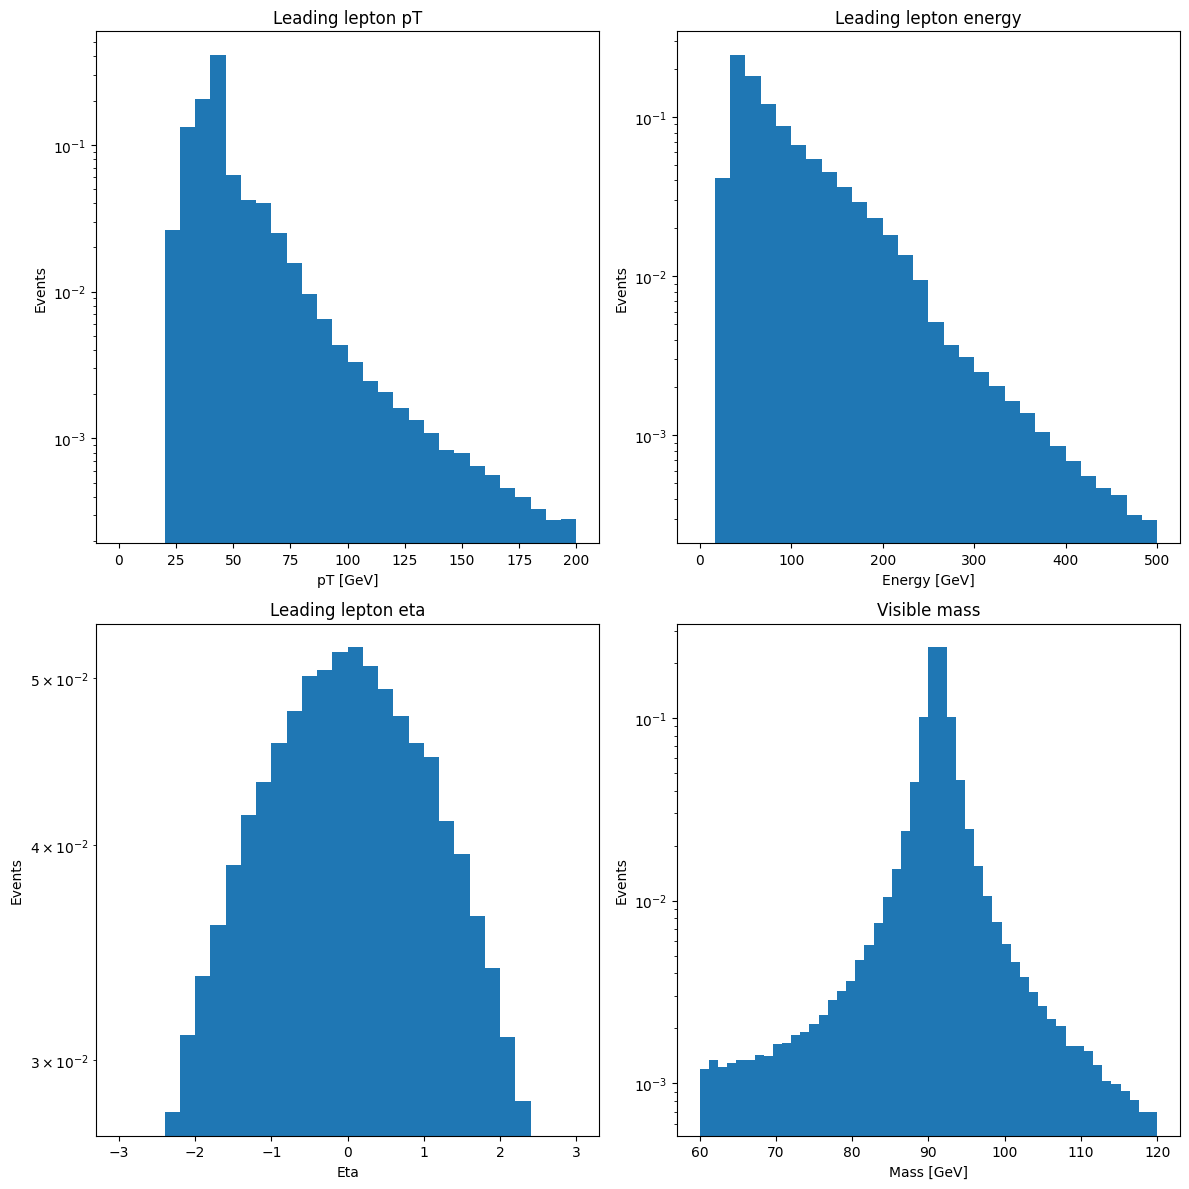

In [5]:
import matplotlib.pyplot as plt

weights = [1 / len(df)] * len(df)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].hist(df["pt_lead"], bins=30, range=(0, 200), weights=weights)
axs[0, 0].set_title("Leading lepton pT")
axs[0, 0].set_xlabel("pT [GeV]")
axs[0, 0].set_ylabel("Events")
axs[0, 0].set_yscale("log")

axs[0, 1].hist(df["energy_lead"], bins=30, range=(0, 500), weights=weights)
axs[0, 1].set_title("Leading lepton energy")
axs[0, 1].set_xlabel("Energy [GeV]")
axs[0, 1].set_ylabel("Events")
axs[0, 1].set_yscale("log")

axs[1, 0].hist(df["eta_lead"], bins=30, range=(-3, 3), weights=weights)
axs[1, 0].set_title("Leading lepton eta")
axs[1, 0].set_xlabel("Eta")
axs[1, 0].set_ylabel("Events")
axs[1, 0].set_yscale("log")

axs[1, 1].hist(df["m_vis"], bins=50, range=(60, 120), weights=weights)
axs[1, 1].set_title("Visible mass")
axs[1, 1].set_xlabel("Mass [GeV]")
axs[1, 1].set_ylabel("Events")
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

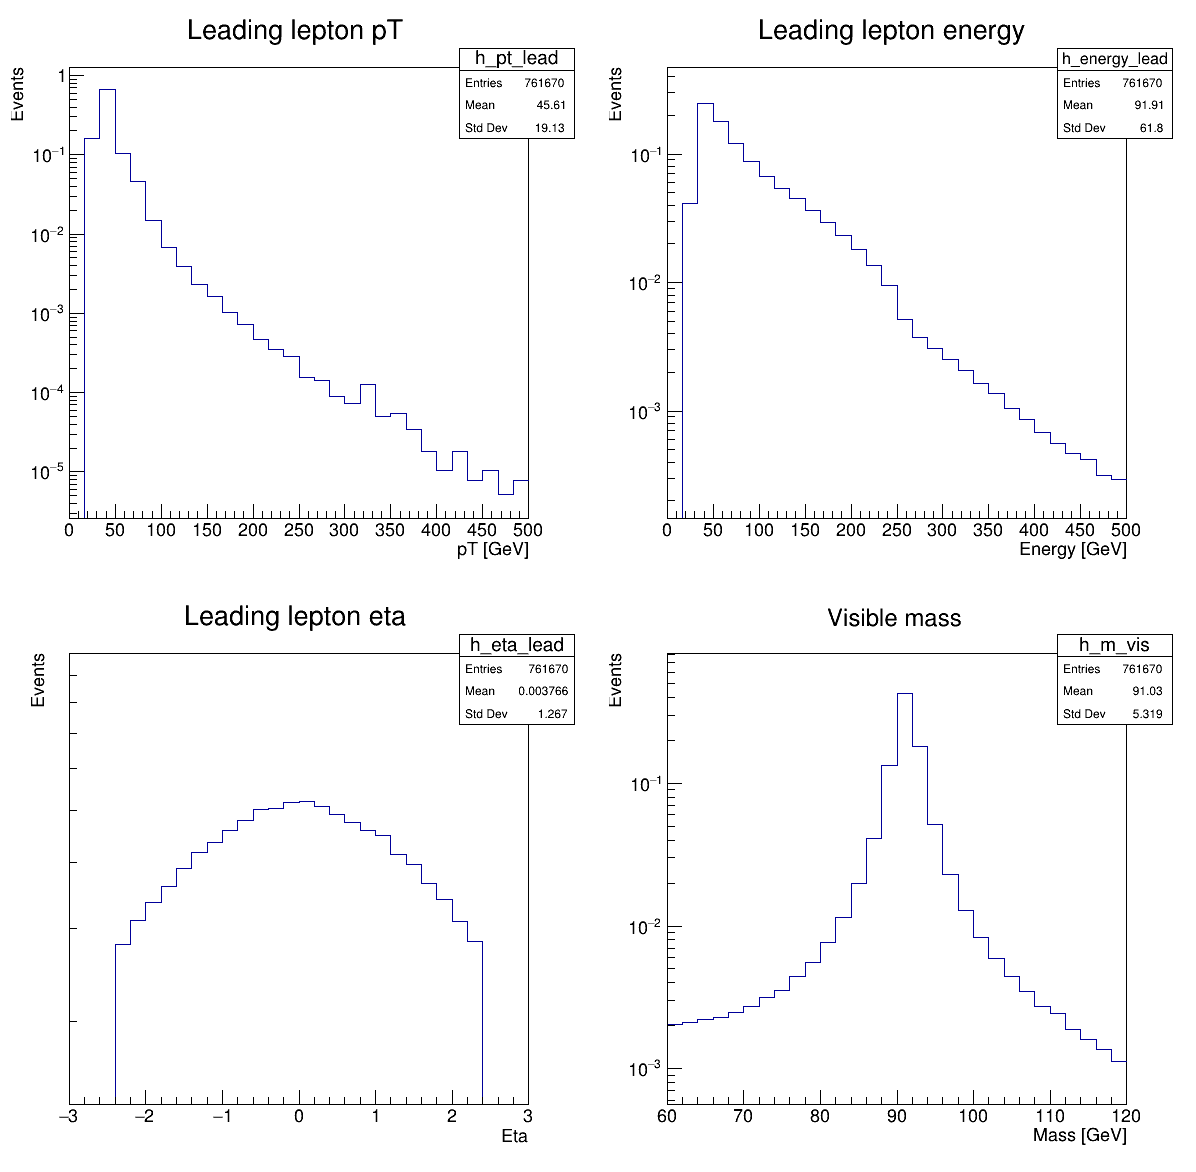

In [6]:
import ROOT
import pandas as pd

# Create histograms
h_pt_lead = ROOT.TH1F(
    "h_pt_lead", "Leading lepton pT; pT [GeV]; Events", 30, 0, 500
)
h_energy_lead = ROOT.TH1F(
    "h_energy_lead", "Leading lepton energy; Energy [GeV]; Events", 30, 0, 500
)
h_eta_lead = ROOT.TH1F(
    "h_eta_lead", "Leading lepton eta; Eta; Events", 30, -3, 3
)
h_m_vis = ROOT.TH1F("h_m_vis", "Visible mass; Mass [GeV]; Events", 30, 60, 120)

# Fill histograms
for index, row in df.iterrows():
    h_pt_lead.Fill(row["pt_lead"])
    h_energy_lead.Fill(row["energy_lead"])
    h_eta_lead.Fill(row["eta_lead"])
    h_m_vis.Fill(row["m_vis"])

# Scale histograms
scale_factor = 1.0 / len(df)
h_pt_lead.Scale(scale_factor)
h_energy_lead.Scale(scale_factor)
h_eta_lead.Scale(scale_factor)
h_m_vis.Scale(scale_factor)

# Create canvas
c = ROOT.TCanvas("c", "Histograms", 1200, 1200)
c.Divide(2, 2)

# Draw histograms
c.cd(1)
ROOT.gPad.SetLogy()
h_pt_lead.Draw("hist")

c.cd(2)
ROOT.gPad.SetLogy()
h_energy_lead.Draw("hist")

c.cd(3)
ROOT.gPad.SetLogy()
h_eta_lead.Draw("hist")

c.cd(4)
ROOT.gPad.SetLogy()
h_m_vis.Draw("hist")

c.Update()
c.Draw()

## Extract kinematic distributions at Delphes level. 

In [7]:
from hep_pheno_tools.delphes_reader.loader import DelphesLoader
from hep_pheno_tools.delphes_reader.classifier import get_electrons, get_muons
from ROOT import TChain
import pandas as pd


def get_df_by_delphes_signal(sample_name, sample_path):

    # There are backgrounds with more than 2^24 (~16.8*10^6) events. So we can't load all the events in the same TChain
    sample = DelphesLoader(sample_name, path=sample_path)
    forest = sample.Forest

    entry = 0
    passed_events = 0
    results = []
    for tree in forest:
        chain = TChain("Delphes;1")
        chain.Add(tree)
        for event in chain:
            entry += 1
            electrons = get_electrons(event)
            muons = get_muons(event)

            # Exactly two same-flavour opposite-charge (SFOS) leptons (electrons or muons) with pT>25 GeV;

            ## check if there are two leptons
            if len(electrons) + len(muons) != 2:
                continue

            ## both leptons must have the same flavor
            if len(electrons) == 2:
                leptons = electrons
            elif len(muons) == 2:
                leptons = muons
            else:
                continue

            ## both leptons must have opposite charge
            if leptons[0].charge * leptons[1].charge > 0:
                continue

            ## both leptons must have pT > 25 GeV
            if leptons[0].pt < 25 or leptons[1].pt < 25:
                continue

            ## both leptons must be in the aceptance region, |eta| < 2.4
            if abs(leptons[0].eta) > 2.4 or abs(leptons[1].eta) > 2.4:
                continue

            ## both leptons must pass the isolation criteria
            if leptons[0].delta_R(leptons[1]) < 0.4:
                continue

            lead_lepton = (
                leptons[0] if leptons[0].pt > leptons[1].pt else leptons[1]
            )

            kin_row = {}
            kin_row["pdgid"] = 11 if len(electrons) == 2 else 13
            kin_row["pt_l-"] = (
                leptons[0].pt if leptons[0].charge < 0 else leptons[1].pt
            )
            kin_row["pt_l+"] = (
                leptons[0].pt if leptons[0].charge > 0 else leptons[1].pt
            )
            kin_row["pt_lead"] = lead_lepton.pt
            kin_row["energy_lead"] = lead_lepton.energy
            kin_row["eta_lead"] = lead_lepton.eta
            kin_row["charge_lead"] = lead_lepton.charge
            kin_row["m_vis"] = (leptons[0].tlv + leptons[1].tlv).M()

            ## the reconstructed mass must be in the Z boson mass window
            if kin_row["m_vis"] < 66 or kin_row["m_vis"] > 116:
                continue

            results.append(kin_row)
            passed_events += 1

    df = pd.DataFrame.from_records(results)
    df["efficiency"] = [passed_events / entry] * len(df)
    return df

In [ ]:
background_dirs = {
    "single_top": "/disco1/BKG_SM/stop",
    "ttbar": "/disco1/BKG_SM/ttbar",
    #"w_jets": "/disco3/BKG_SM/w+jets/",
    "ww": "/disco2/BKG_SM/ww",
    "wz": "/disco2/BKG_SM/wz",
    "zz": "/disco2/BKG_SM/zz",
}
mc_samples_dirs = {"z_to_leptons": signal_dir, **background_dirs}
mc_samples_dirs

mc_samples_df = {}
for sample_name, sample_path in mc_samples_dirs.items():
    df_file = os.path.join(data_dir, f"{sample_name}_delphes.feather")
    if not os.path.exists(df_file) or run_simulations == True:
        print(f"Reading {sample_name} Delphes files")
        df = get_df_by_delphes_signal(sample_name, sample_path)
        df.to_feather(df_file)
    else:
        df = pd.read_feather(df_file)
    mc_samples_df[sample_name] = df

    print(f"{sample_name} has {len(df)} montecarlo events")

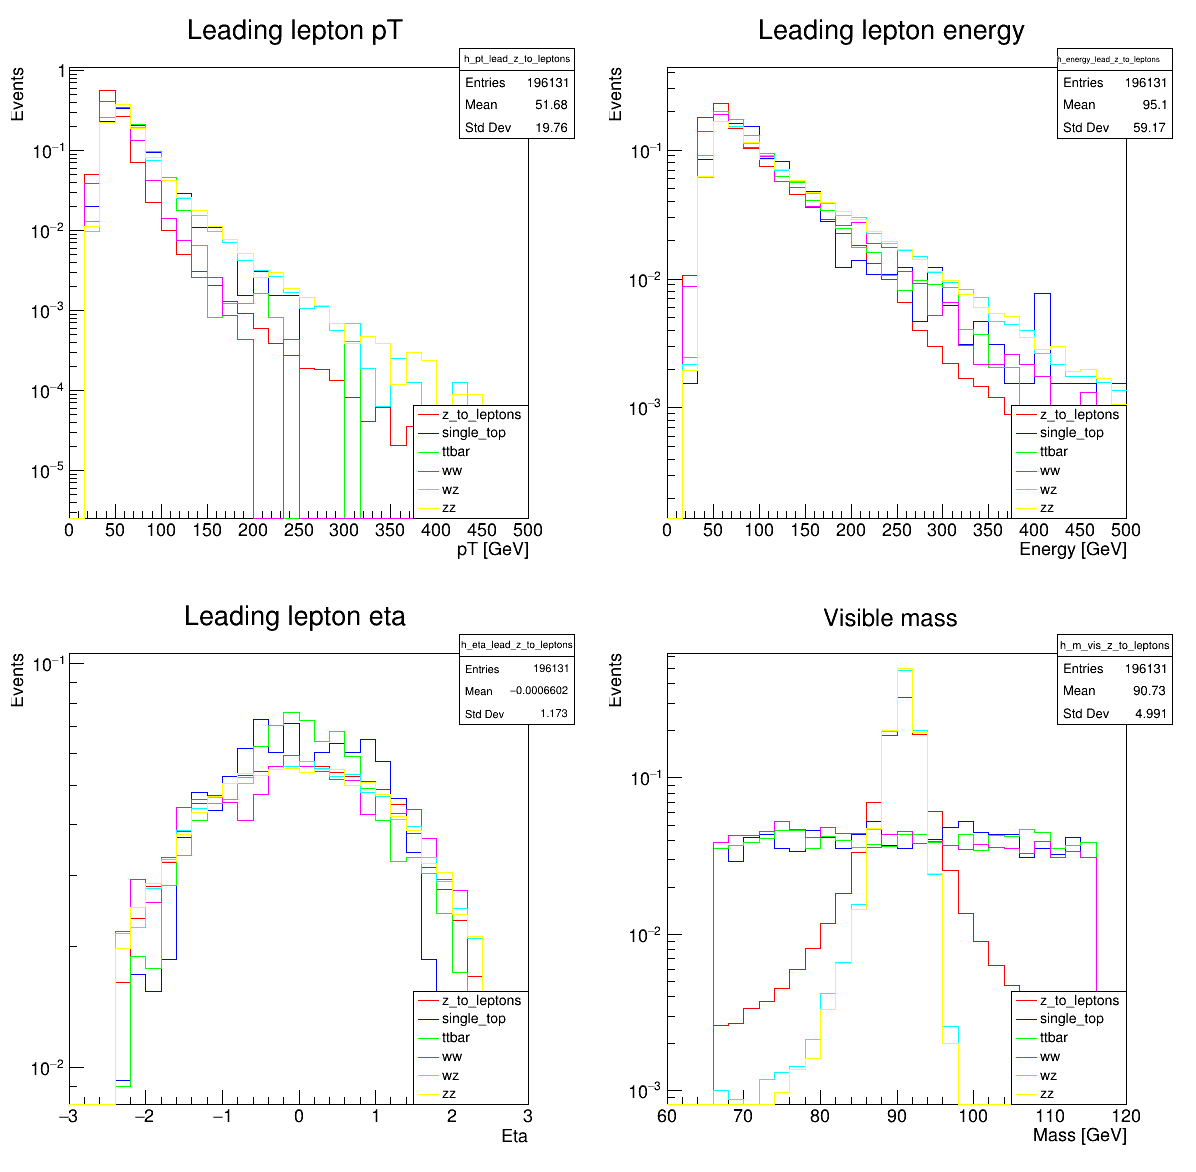

In [9]:
#plot in pyroot the histograms

# Create and fill histograms
histograms = {}
for sample_name, df in mc_samples_df.items():
    h_pt_lead = ROOT.TH1F(
        f"h_pt_lead_{sample_name}",
        f"Leading lepton pT; pT [GeV]; Events",
        30,
        0,
        500,
    )
    h_energy_lead = ROOT.TH1F(
        f"h_energy_lead_{sample_name}",
        f"Leading lepton energy; Energy [GeV]; Events",
        30,
        0,
        500,
    )
    h_eta_lead = ROOT.TH1F(
        f"h_eta_lead_{sample_name}",
        f"Leading lepton eta; Eta; Events",
        30,
        -3,
        3,
    )
    h_m_vis = ROOT.TH1F(
        f"h_m_vis_{sample_name}",
        f"Visible mass ; Mass [GeV]; Events",
        30,
        60,
        120,
    )

    # Fill histograms
    for index, row in df.iterrows():
        h_pt_lead.Fill(row["pt_lead"])
        h_energy_lead.Fill(row["energy_lead"])
        h_eta_lead.Fill(row["eta_lead"])
        h_m_vis.Fill(row["m_vis"])

    # Scale histograms
    try: 
        scale_factor = 1.0 / len(df)
    except ZeroDivisionError:
        scale_factor = 0
    h_pt_lead.Scale(scale_factor)
    h_energy_lead.Scale(scale_factor)
    h_eta_lead.Scale(scale_factor)
    h_m_vis.Scale(scale_factor)

    histograms[sample_name] = {
        "pt_lead": h_pt_lead,
        "energy_lead": h_energy_lead,
        "eta_lead": h_eta_lead,
        "m_vis": h_m_vis,
    }
# List of colors to cycle through
colors = [
    ROOT.kRed, ROOT.kBlue, ROOT.kGreen, ROOT.kMagenta, ROOT.kCyan, 
    ROOT.kYellow, ROOT.kOrange, ROOT.kViolet, ROOT.kPink, ROOT.kTeal
]

# Create canvas
c = ROOT.TCanvas("c_all_samples", "Histograms for all samples", 1200, 1200)
c.Divide(2, 2)

# Initialize color counter
color_counter = 0

# Create legend
legend = ROOT.TLegend(0.7, 0.1, 0.9, 0.3)

for sample_name, hist_dict in histograms.items():
    h_pt_lead = hist_dict["pt_lead"]
    h_energy_lead = hist_dict["energy_lead"]
    h_eta_lead = hist_dict["eta_lead"]
    h_m_vis = hist_dict["m_vis"]

    # Set colors using the counter
    color = colors[color_counter % len(colors)]
    h_pt_lead.SetLineColor(color)
    h_energy_lead.SetLineColor(color)
    h_eta_lead.SetLineColor(color)
    h_m_vis.SetLineColor(color)

    # Add entry to legend
    legend.AddEntry(h_pt_lead, sample_name, "l")

    # Increment color counter
    color_counter += 1

    # Draw histograms
    c.cd(1)
    ROOT.gPad.SetLogy()
    if sample_name == "z_to_leptons":
        h_pt_lead.Draw("hist")
    else:
        h_pt_lead.Draw("hist same")
    c.cd(2)
    ROOT.gPad.SetLogy()
    if sample_name == "z_to_leptons":
        h_energy_lead.Draw("hist")
    else:
        h_energy_lead.Draw("hist same")

    c.cd(3)
    ROOT.gPad.SetLogy()
    if sample_name == "z_to_leptons":
        h_eta_lead.Draw("hist")
    else:
        h_eta_lead.Draw("hist same")

    c.cd(4)
    ROOT.gPad.SetLogy()
    if sample_name == "z_to_leptons":
        h_m_vis.Draw("hist")
    else:
        h_m_vis.Draw("hist same")

c.cd(1)
legend.Draw("hist")

c.cd(2)
legend.Draw("hist")

c.cd(3)
legend.Draw("hist")

c.cd(4)
legend.Draw("hist")


c.Update()
c.Draw()



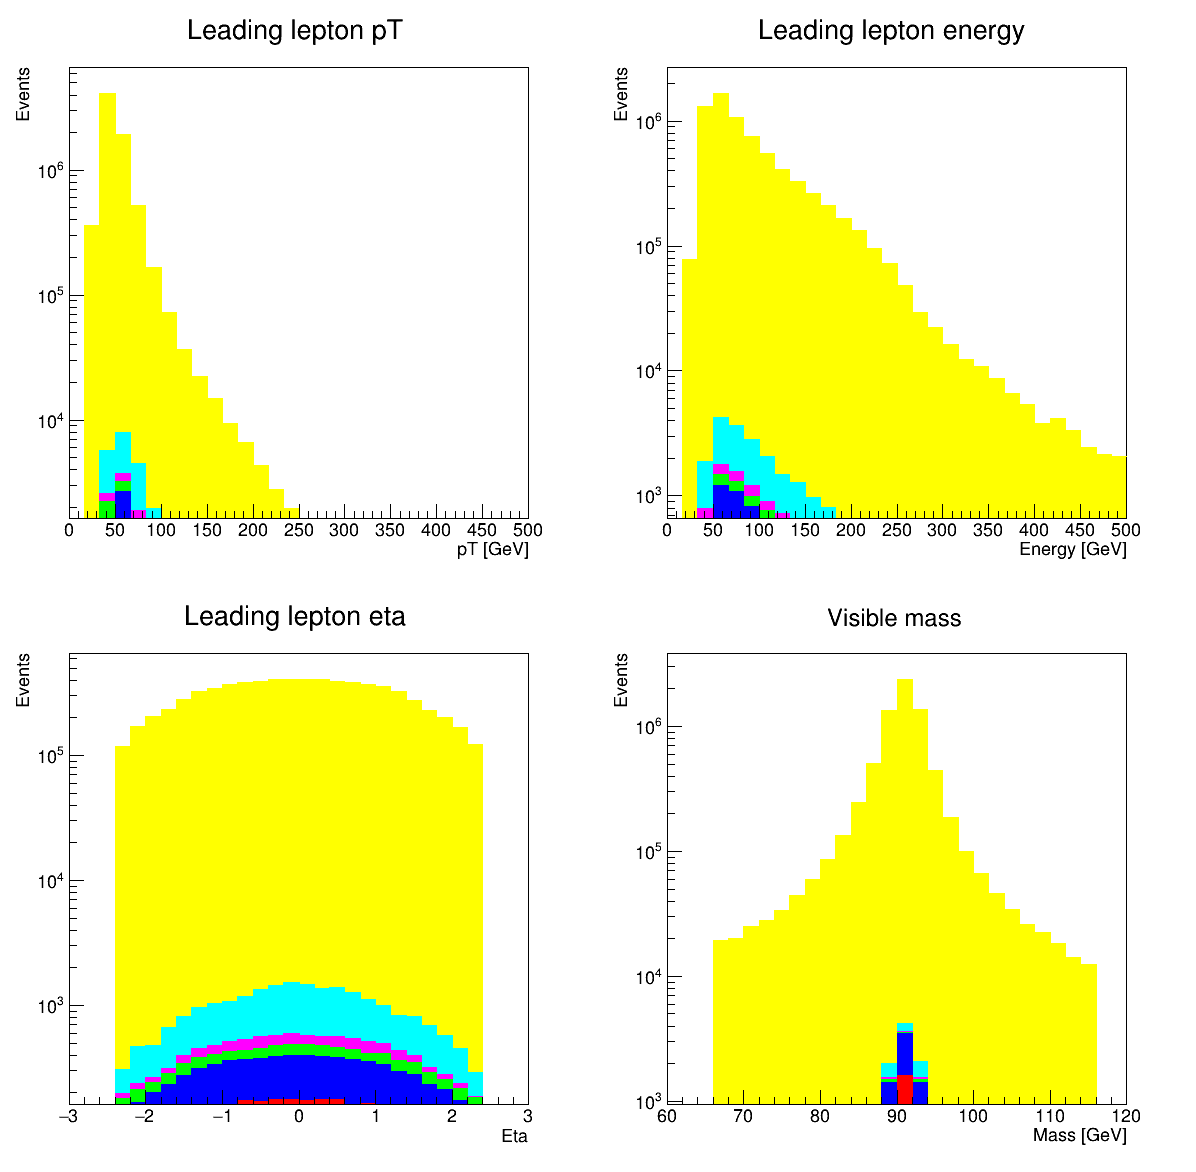

In [10]:
# Normalize to 10 fb-1

background_xs = {
    "single_top": 241.17, # pb
    "ttbar": 504.696, # pb
    "w_jets": 146548.3, # pb
    "ww": 65.50736, # pb
    "zz": 9.562416, # pb
    "wz": 24.69184, # pb
}

sample_cross_sections = { **background_xs, "z_to_leptons": 2215.33 } # pb

luminosity = 10  # fb-1

hist_stack_pt_lead = ROOT.THStack("hs_pt_lead", "Leading lepton pT; pT [GeV]; Events")
hist_stack_energy_lead = ROOT.THStack("hs_energy_lead", "Leading lepton energy; Energy [GeV]; Events")
hist_stack_eta_lead = ROOT.THStack("hs_eta_lead", "Leading lepton eta; Eta; Events")
hist_stack_m_vis = ROOT.THStack("hs_m_vis", "Visible mass; Mass [GeV]; Events")

# sort hist_dict by cross section
histograms = dict(sorted(histograms.items(), key=lambda item: sample_cross_sections[item[0]]))
# Initialize color counter
color_counter = 0

for sample_name, hist_dict in histograms.items():
    h_pt_lead = hist_dict["pt_lead"]
    h_energy_lead = hist_dict["energy_lead"]
    h_eta_lead = hist_dict["eta_lead"]
    h_m_vis = hist_dict["m_vis"]

    # Normalize histograms
    scale_factor = luminosity * sample_cross_sections[sample_name] * 1e3 * mc_samples_df[sample_name]["efficiency"].mean()
    h_pt_lead.Scale(scale_factor / h_pt_lead.Integral())
    h_energy_lead.Scale(scale_factor / h_energy_lead.Integral())
    h_eta_lead.Scale(scale_factor / h_eta_lead.Integral())
    h_m_vis.Scale(scale_factor / h_m_vis.Integral())

    # Set Fill color
    color = colors[color_counter % len(colors)]
    h_pt_lead.SetFillColor(color)
    h_energy_lead.SetFillColor(color)
    h_eta_lead.SetFillColor(color)
    h_m_vis.SetFillColor(color)

    # set line color
    h_pt_lead.SetLineColor(color)
    h_energy_lead.SetLineColor(color)
    h_eta_lead.SetLineColor(color)
    h_m_vis.SetLineColor(color)
    
    # Increment color counter
    color_counter += 1

    # Add histograms to stack
    hist_stack_pt_lead.Add(h_pt_lead)
    hist_stack_energy_lead.Add(h_energy_lead)
    hist_stack_eta_lead.Add(h_eta_lead)
    hist_stack_m_vis.Add(h_m_vis)

# Create canvas
c_norm = ROOT.TCanvas("c_norm", "Normalized histograms", 1200, 1200)
c_norm.Divide(2, 2)

# Draw histograms
c_norm.cd(1)
ROOT.gPad.SetLogy()
hist_stack_pt_lead.Draw("hist")

c_norm.cd(2)
ROOT.gPad.SetLogy()
hist_stack_energy_lead.Draw("hist")

c_norm.cd(3)
ROOT.gPad.SetLogy()
hist_stack_eta_lead.Draw("hist")

c_norm.cd(4)
ROOT.gPad.SetLogy()
hist_stack_m_vis.Draw("hist")

c_norm.Update()
c_norm.Draw()

# Compare with Atlas Open Data

In [11]:
from hep_pheno_tools.atlas_reader import download_atlas_opendataset
from hep_pheno_tools.atlas_reader.classifier import get_leptons
from ROOT import TChain
import pandas as pd
import os

atlas_data = "2lep"
atlas_data_dir = os.path.join(output_dir, f"atlas_{atlas_data}")
extracted_data_dir = os.path.join(data_dir, f"atlas_{atlas_data}.feather")
os.makedirs(atlas_data_dir, exist_ok=True)

forest = download_atlas_opendataset(atlas_data, atlas_data_dir)
if not os.path.exists(extracted_data_dir):
    results = []
    for tree in forest:
        chain = TChain("mini")
        chain.Add(tree)
        for event in chain:
            # check if there are two leptons before applying any selection
            if event.lep_n != 2:
                continue

            leptons = get_leptons(event)

            ## both leptons must have the same flavor
            if abs(leptons[0].pdgid) != abs(leptons[1].pdgid):
                continue

            ## both leptons must have opposite charge
            if leptons[0].charge * leptons[1].charge > 0:
                continue

            ## both leptons must have pT > 25 GeV
            if leptons[0].pt < 25 or leptons[1].pt < 25:
                continue

            ## both leptons must be in the aceptance region, |eta| < 2.3
            if abs(leptons[0].eta) > 2.3 or abs(leptons[1].eta) > 2.3:
                continue

            ## both leptons must pass the isolation criteria
            if leptons[0].delta_R(leptons[1]) < 0.4:
                continue

            lead_lepton = (
                leptons[0] if leptons[0].pt > leptons[1].pt else leptons[1]
            )

            kin_row = {}
            kin_row["pdgid"] = abs(leptons[0].pdgid)
            kin_row["pt_l-"] = (
                leptons[0].pt if leptons[0].charge < 0 else leptons[1].pt
            )
            kin_row["pt_l+"] = (
                leptons[0].pt if leptons[0].charge > 0 else leptons[1].pt
            )
            kin_row["pt_lead"] = lead_lepton.pt
            kin_row["energy_lead"] = lead_lepton.energy
            kin_row["eta_lead"] = lead_lepton.eta
            kin_row["charge_lead"] = lead_lepton.charge
            kin_row["m_vis"] = (leptons[0].tlv + leptons[1].tlv).M()
            ## the reconstructed mass must be in the Z boson mass window
            if kin_row["m_vis"] < 66 or kin_row["m_vis"] > 116:
                continue
            
            
            results.append(kin_row)

    atlas_data_df = pd.DataFrame.from_records(results)
    atlas_data_df.to_feather(extracted_data_dir)
else:
    atlas_data_df = pd.read_feather(extracted_data_dir)

atlas_data_df.head()

,pdgid,pt_l-,pt_l+,pt_lead,energy_lead,eta_lead,charge_lead,m_vis
0,11,37.205387,42.871246,42.871246,42.967840,0.067116,1,89.282450
1,11,29.222084,33.070188,33.070188,35.314297,-0.366347,1,88.274722
2,11,49.459629,35.819855,49.459629,99.119836,-1.319296,-1,91.529040
3,11,36.633945,49.670844,49.670844,123.383805,1.559802,1,90.955708
4,13,25.529799,27.137146,27.137146,119.077203,-2.158771,1,88.339121


In [12]:
import ROOT
import pandas as pdS

# Create histograms
h_pt_lead_data = ROOT.TH1F(
    "h_pt_lead_data", "Leading lepton pT; pT [GeV]; Events", 30, 0, 500
)
h_energy_lead_data = ROOT.TH1F(
    "h_energy_lead_data", "Leading lepton energy; Energy [GeV]; Events", 30, 0, 500
)
h_eta_lead_data = ROOT.TH1F(
    "h_eta_lead_data", "Leading lepton eta; Eta; Events", 30, -3, 3
)
h_m_vis_data = ROOT.TH1F("h_m_vis_data", "Visible mass; Mass [GeV]; Events", 30, 60, 120)

# Fill histograms
for index, row in atlas_data_df.iterrows():
    h_pt_lead_data.Fill(row["pt_lead"])
    h_energy_lead_data.Fill(row["energy_lead"])
    h_eta_lead_data.Fill(row["eta_lead"])
    h_m_vis_data.Fill(row["m_vis"])


ALWAYS THE DATA HAS STATISTICAL WEIGHT = 1, So we don't need rescale the histograms

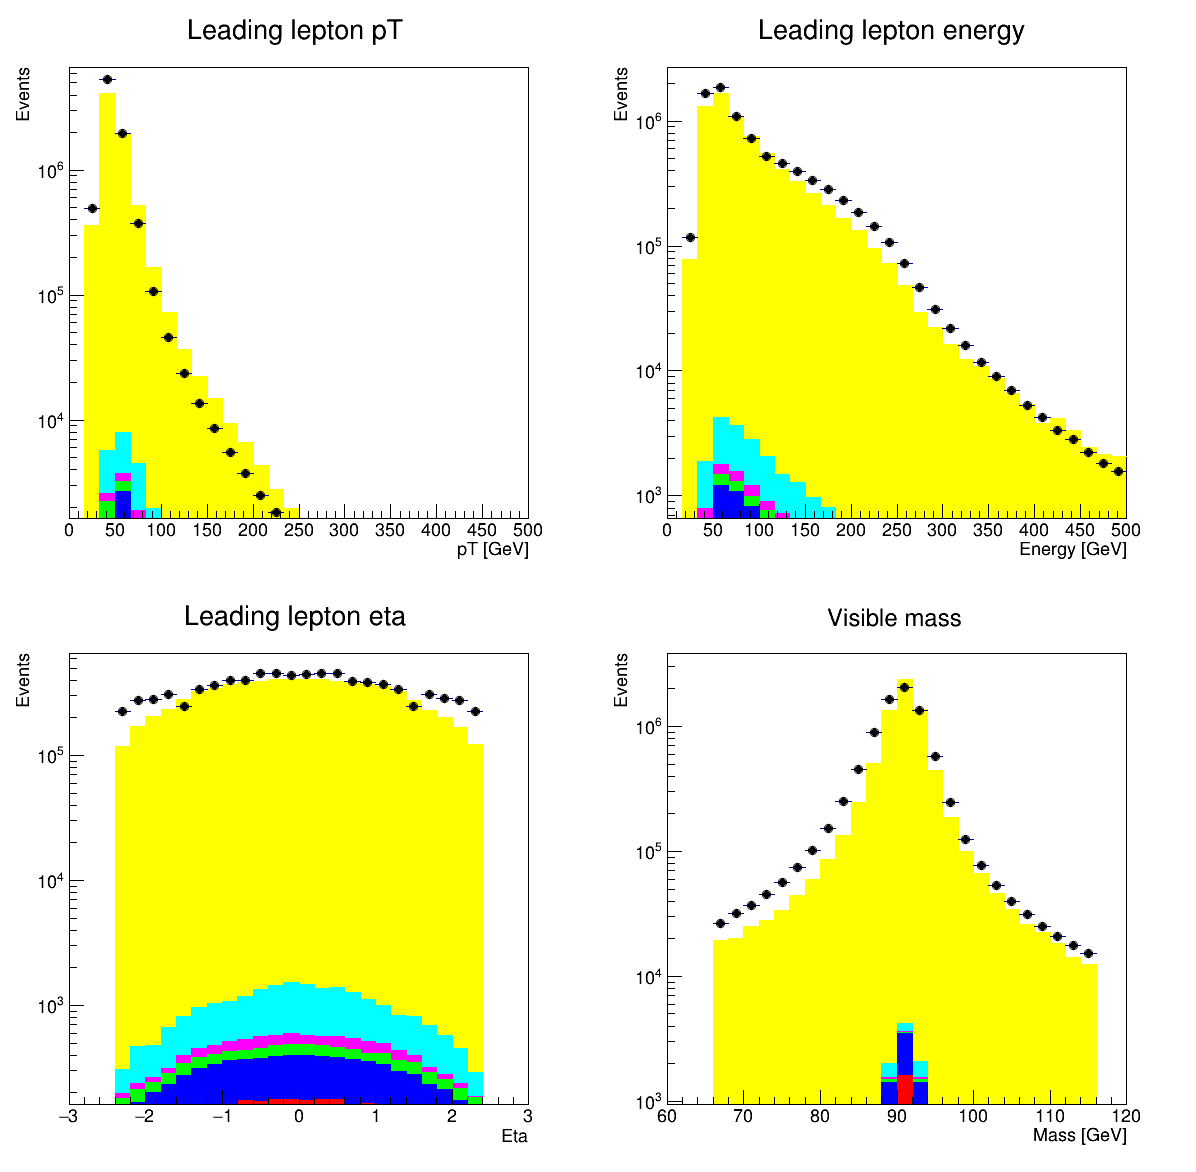

In [13]:
# Create canvas
c = ROOT.TCanvas("c", "Histograms", 1200, 1200)
c.Divide(2, 2)

# Draw histograms
c.cd(1)
ROOT.gPad.SetLogy()
hist_stack_pt_lead.Draw("hist")
h_pt_lead_data.SetMarkerSize(1)
h_pt_lead_data.SetMarkerStyle(20)
h_pt_lead_data.Draw("ep same")


c.cd(2)
ROOT.gPad.SetLogy()
hist_stack_energy_lead.Draw("hist")
h_energy_lead_data.SetMarkerSize(1)
h_energy_lead_data.SetMarkerStyle(20)
h_energy_lead_data.Draw("ep same")

c.cd(3)
ROOT.gPad.SetLogy()
hist_stack_eta_lead.Draw("hist")
h_eta_lead_data.SetMarkerSize(1)
h_eta_lead_data.SetMarkerStyle(20)
h_eta_lead_data.Draw("ep same")

c.cd(4)
ROOT.gPad.SetLogy()
hist_stack_m_vis.Draw("hist")
h_m_vis_data.SetMarkerSize(1)
h_m_vis_data.SetMarkerStyle(20)
h_m_vis_data.Draw("ep same")


c.Update()
c.Draw()